<a href="https://colab.research.google.com/github/barronh/pseudonetcdf_examples/blob/main/cmaq_mask_maker/cmaq_mask_maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make a Mask

    author: Barron H. Henderson
    date: 2020-10-02

This notebook creates a time-independent file "mask" file. The values are 
fractional and represent how much of the grid cell is contained within an
analysis area. These are useful for CMAQ DESID. 

As an illustration, this notebook creates one file for Alabama and another file
using a custom definition around the "Four Corners" region.

Overview:
1. Import Libraries
2. Make a mask from a shapefile
3. Make a mask using custom modification

# Import Libraries

* `pyproj` used for geographic to projected coordinate transformations
* `PseudoNetCDF` used for easy access
* `numpy` used for numeric computation
* `shapefile` (i.e., pyshp) used to read shapefiles
* `shapely` used perform spatial operations
* `pycno` used to add overlays to maps

The commands below will add these libraries on Colab. If you are on a system that already has them, you can skip this step or set `colab = False`. If you are on a system that does not have them and you are not an administrator, you can add `--user` to each of these commands to install in your user space.

In [1]:
colab = True
if colab:
  !pip install pyproj==2
  !pip install pseudonetcdf
  !pip install pyshp
  !pip install pycno

     |████████████████████████████████| 20.6MB 1.2MB/s 
     |████████████████████████████████| 296kB 9.1MB/s 
     |████████████████████████████████| 4.7MB 15.2MB/s 
     |████████████████████████████████| 296kB 43.8MB/s 
  Created wheel for pseudonetcdf: filename=PseudoNetCDF-3.1.0-cp36-none-any.whl size=381602 sha256=2f9a2bec733e11cbeb857627f5a13c8495ed24c45a0fc18a94eab964568ab78e
  Stored in directory: /root/.cache/pip/wheels/67/60/39/396c6c766c12819eeaf87167b9721c4336dd40a32cdb73a6d6
Successfully built pseudonetcdf
     |████████████████████████████████| 225kB 7.1MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.2-cp36-none-any.whl size=36217 sha256=d852a80b6da3490361db517d66cd063fa066e52cb52c926c99ba05dc686419f3
  Stored in directory: /root/.cache/pip/wheels/96/6c/53/4112475adf3b831da97f083163d0f38ee6daac9c1b13f7afea
Successfully built pyshp


In [2]:
import PseudoNetCDF as pnc
import pycno
import numpy as np
import os
import matplotlib.pyplot as plt
import shapefile as shp
from shapely.geometry import Polygon, Point
from shapely.prepared import prep
from shapely.ops import cascaded_union
from google.colab import files

os.environ['IOAPI_ISPH'] = '6370000.'

# Make a mask from a shapefile

* Read in a shapefile
* Filter the shapes
* Find all cells in the filtered shapes
* Save out an IOAPI file

# Using GADM Shapefile

* Global ADMinistrative project provides shapefiles of administrative boundaries (https://gadm.org/)
* We use the global file, but you could also use a region specific file
* The file should be at the path specified below.

In [3]:
!wget --continue https://biogeo.ucdavis.edu/data/gadm3.6/gadm36_shp.zip

--2021-01-12 16:16:51--  https://biogeo.ucdavis.edu/data/gadm3.6/gadm36_shp.zip
Resolving biogeo.ucdavis.edu (biogeo.ucdavis.edu)... 128.120.228.172
Connecting to biogeo.ucdavis.edu (biogeo.ucdavis.edu)|128.120.228.172|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.biogeo.ucdavis.edu/data/gadm3.6/gadm36_shp.zip [following]
--2021-01-12 16:16:52--  https://data.biogeo.ucdavis.edu/data/gadm3.6/gadm36_shp.zip
Resolving data.biogeo.ucdavis.edu (data.biogeo.ucdavis.edu)... 128.120.228.172
Connecting to data.biogeo.ucdavis.edu (data.biogeo.ucdavis.edu)|128.120.228.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562883070 (537M) [application/zip]
Saving to: ‘gadm36_shp.zip’

gadm36_shp.zip      100%[===================>] 536.81M  38.2MB/s    in 15s     

2021-01-12 16:17:07 (37.0 MB/s) - ‘gadm36_shp.zip’ saved [562883070/562883070]



In [4]:
!unzip gadm36_shp.zip

Archive:  gadm36_shp.zip
 extracting: gadm36.cpg              
  inflating: gadm36.dbf              
  inflating: gadm36.prj              
  inflating: gadm36.shp              
  inflating: gadm36.shx              


In [5]:
gadmpath = 'gadm36'

## Open and Understand the Shapefile

* Use `shapefile.Reader` to open the file
  * if you get an error, try adding the encoding='latin1' option
* Get a list of field names
* Print IDs and example values

In [6]:
shpf = shp.Reader(gadmpath)

In [7]:
fldnames = [n for n, t, l, d in shpf.fields][1:]

In [8]:
example_rec = shpf.record(0)
for i, name in enumerate(fldnames[:10]):
    print(i, name, example_rec[i])

0 UID 183022
1 GID_0 AFG
2 ID_0 1
3 NAME_0 Afghanistan
4 GID_1 AFG.1_1
5 ID_1 1
6 NAME_1 Badakhshan
7 VARNAME_1 Badahšan
8 NL_NAME_1 
9 HASC_1 AF.BD


## Filter Records

* We use the United States Alabama record HASC_1 value to find all polygons in Alabama
* Multiple polygons represent islands etc.

In [9]:
recordnums = [ri for ri, rec in enumerate(shpf.iterRecords()) if rec[9] == 'US.AL']

## For each record

* Get the Shapefile shapes
* Transform them into polygons
* Polygons will be used over and over, so also create `prepared` polygons that have fast `contains` method
* Create an uber polygon that encompasses all the little polygons

In [10]:
shapes = [shpf.shape(rn) for rn in recordnums]

In [11]:
polygons = [Polygon(s.points).buffer(0) for s in shapes]
ppolygons = [prep(p) for p in polygons]

In [12]:
uberpoly = cascaded_union(polygons)
puberpoly = prep(uberpoly)

## Get cell centroids

* Open a file with LAT/LON

In [13]:
with open('GRIDDESC', 'w') as gf:
  gf.write("""' '
'LamCon_40N_97W'
 2 33.000 45.000 -97.000 -97.000 40.000
'POLSTE_HEMI'
 6         1.000        45.000       -98.000       -98.000        90.000
'LATLON'
1  0.0 0.0 0.0 0.0 0.0
' '
'global_1'
'LATLON'  -180.0 -90.0 1.0 1.0  360  180 1
'global_0pt1'
'LATLON'  -180.0 -90.0 0.1 0.1  3600  1800 1
'108NHEMI2'
'POLSTE_HEMI' -10098000.000 -10098000.000    108000.000    108000.000 187 187   1
'12US1'
'LamCon_40N_97W' -2556000.0 -1728000.0 12000.0 12000.0 459 299 1
'12US2'
'LamCon_40N_97W'     -2412000.0 -1620000.0 12000.0 12000.0 396 246 1
'36US3'
'LamCon_40N_97W'  -2952000.000  -2772000.000     36000.000     36000.000 172  148   1
' '
""")

In [14]:
gf = pnc.pncopen('GRIDDESC', format='griddesc', GDNAM='12US2')

In [15]:
Ipl1, Jpl1 = np.meshgrid(np.arange(gf.NCOLS + 1), np.arange(gf.NROWS + 1))
LONp1, LATp1 = gf.ij2ll(Ipl1, Jpl1)
Xp1, Yp1 = gf.ll2xy(LONp1, LATp1)
LOND, LATD = gf.xy2ll(Xp1 - gf.XCELL / 2, Yp1 - gf.YCELL / 2)
LON = LONp1[:-1, :-1]
LAT = LATp1[:-1, :-1]

## Create an Outfile

* Using eval to make an empty variable
* Then iterating through centroids
  * If within uber polygon, check each polygon
  * If within any polygon, set the value to 1 and quit checking

In [16]:
gf.SDATE = 2019001
outf = gf.eval("MINE = DUMMY[:] * 0")
MINE = outf.variables['MINE']
MINE.units = 'fraction'
MINE.long_name = 'MINE'
MINE.var_desc = '0 means not mine, 1 means all mine, inbetween is partial'

In [17]:
%%time
fractional = True
for j, i in np.ndindex(gf.NROWS, gf.NCOLS):
    if fractional:
        gpoly = Polygon([
            [LOND[j + 0, i + 0], LATD[j + 0, i + 0]],
            [LOND[j + 0, i + 1], LATD[j + 0, i + 1]],
            [LOND[j + 1, i + 1], LATD[j + 1, i + 1]],
            [LOND[j + 1, i + 0], LATD[j + 1, i + 0]],
            [LOND[j + 0, i + 0], LATD[j + 0, i + 0]],
        ])
        if puberpoly.intersects(gpoly):
            intx = gpoly.intersection(uberpoly)
            farea = intx.area / gpoly.area
            MINE[0, 0, j, i] = farea
    else:
        gp = Point(LON[j, i], LAT[j, i])
        if puberpoly.contains(gp):
            if uberpoly.contains(gp):
                MINE[0, 0, j, i] = 1


CPU times: user 5.02 s, sys: 1.89 ms, total: 5.02 s
Wall time: 5.04 s


## Plot to Confirm

* Use plot to make a map

/usr/local/lib/python3.6/dist-packages/pycno/__init__.py:258: UserWarning: Downloading: https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_USA_3.cnob to MWDB_Coasts_USA_3.cnob
  warnings.warn('Downloading: ' + url + ' to ' + str(datapatho))


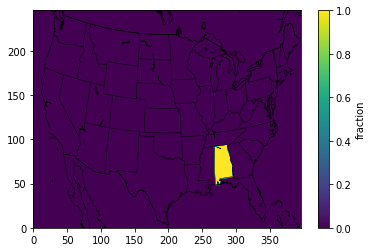

In [18]:
plt.pcolormesh(outf.variables['MINE'][0, 0])
plt.colorbar(label='fraction')
cno = pycno.cno(proj=outf.getproj(withgrid=True), data='.')
cno.draw('MWDB_Coasts_USA_3.cnob');

## Save Mask File

In [19]:
outf.variables['TFLAG'][:] = 0
outf.SDATE = -635
savedf = outf.save('MINE1.nc', verbose=0, complevel=1);
savedf.close()

## Optionally Download

In [20]:
files.download('MINE1.nc')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Make a mask using custom modification

* Make a smiley face as a simplistic example.
* Start by making a circle programatically
* Then save to text file
* Then modify with a text editor
* Then read in the text file.
* Then save the IOAPI file

## Make a Circle

* Open an IOAPI file with LON/LAT
* Create an output file with a degree-based radius circle
* Save the circle to a file
* Edit the file and save as another name
* Read in the new file
* Plot to confirm
* Save out

In [21]:
latv = gf.copyVariable(gf.variables['DUMMY'], 'LAT', withdata=False)
lonv = gf.copyVariable(gf.variables['DUMMY'], 'LON', withdata=False)
latv[:] = LAT[:]
lonv[:] = LON[:]

In [22]:
# Using the four corners monument location
outf = gf.eval('MINE = (((LAT[:] - 36.998972)**2 + (LON[:] - -109.045167)**2)**.5 < 1).astype("f")')
MINE = outf.variables['MINE']
MINE.units = 'fraction'
MINE.long_name = 'MINE'
MINE.var_desc = '0 means not mine, 1 means all mine, inbetween is partial'

In [23]:
np.savetxt('map.txt', outf.variables['MINE'][0, 0, ::-1], fmt='%d', delimiter=' ', newline='\n')

## Make Manual Edits

* Open map.txt in a text editor without wrapping.
* Search for a 1. You should see the circle
* Edit the circle by turning on and off 1s
* Then save

In [28]:
outf.variables['MINE'][:] = np.loadtxt('map.txt', delimiter=" ", dtype='i')[::-1]

## Plot to Confirm

* If you didn't edit, it should be a circle.
* Used the text editor to give it eyes, a nose, a mouth, and hair.

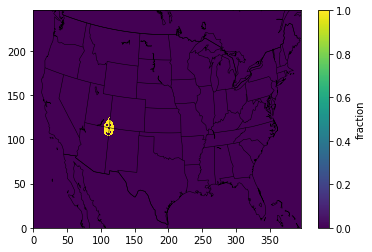

In [29]:
plt.pcolormesh(outf.variables['MINE'][0, 0])
plt.colorbar(label='fraction')
cno = pycno.cno(proj=outf.getproj(withgrid=True), data='.')
cno.draw('MWDB_Coasts_USA_3.cnob');

In [30]:
outf.variables['TFLAG'][:] = 0
outf.SDATE = -635
savedf = outf.save('MINE2.nc', verbose=0, complevel=1);
savedf.close()

## Optionally, download

In [31]:
files.download('MINE2.nc')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>